# XHamster网站数据分析
通过分析xhamster网站的内容得到此报告，旨在分析xhamster的特性，并且针对个人喜好进行自动的学习和打分。

## Part1 数据导入与处理
关于数据的获取，请见!https://github.com/TsingJyujing/DataSpider
数据下载到本地的数据库以后（本文使用的是PostgreSQL数据库），首先需要对网站的内容进行打分，打分的界面仁者见仁，智者见智。
在此只给代码，不赘述了。

In [1]:
# Import libraries
import psycopg2
import numpy as np
import matplotlib
%matplotlib inline  
from matplotlib.pyplot import *

In [2]:
def genSQLConnection():
    return psycopg2.connect(
        database="pvideo",
        user="postgres",
        password="979323",
        host="localhost",
        port="5432")

def getRatedVideos(conn):
    sql_cmd = """
SELECT id, title, img_urls, categories, rating, video_time, myrate
FROM public.xhamster_spider WHERE myrate is not null """
    cur = conn.cursor()
    cur.execute(sql_cmd)
    res = cur.fetchall()
    cur.close()
    return res

def getAllVideos(conn):
    sql_cmd = """
SELECT id, title, img_urls, categories, rating, video_time
FROM public.xhamster_spider"""
    cur = conn.cursor()
    cur.execute(sql_cmd)
    res = cur.fetchall()
    cur.close()
    return res

def getCategoriesSet(res):
    tag_set = set([])
    for row in res:
        tag_set |= set(row[3])
    return tag_set

In [3]:
conn = genSQLConnection()
result_set = getRatedVideos(conn)
result_set_all = getAllVideos(conn)
tags = getCategoriesSet(result_set)
print "get %d tags:" % len(tags)

get 1659 tags:


In [4]:
print len(result_set_all)
Tall = np.zeros(len(result_set_all))
for i, res in enumerate(result_set_all):
    Tall[i] = res[-1]

302332


In [5]:
# give index to tags
tag_index_dict = {}
tag_list = list(tags)
for index, tag in enumerate(tag_list):
    tag_index_dict[tag] = index

In [6]:
# Convert to matrix/vector format
X = np.zeros((len(result_set), len(tag_index_dict)), dtype="float32")
y = np.zeros((len(result_set), 1), dtype="float32")
T = np.zeros((len(result_set), 1), dtype="float32")
for i in range(len(result_set)):
    for tag in result_set[i][3]:
        X[i, tag_index_dict[tag]] = 1
    y[i] = result_set[i][-1]
    T[i] = result_set[i][5]

 ## Part 2 初步的可视化
 首先对数据进行可视化的是时间，首先看一下时间的原始分布：

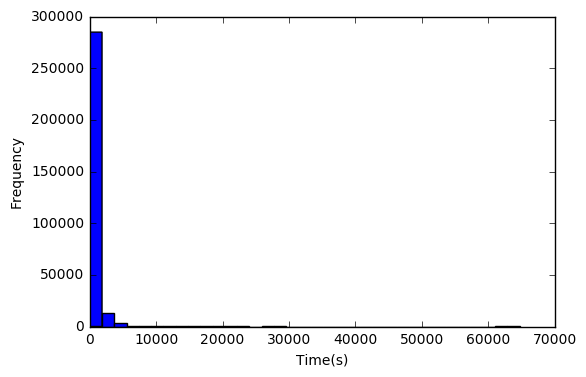

In [7]:
[F, x, p] = hist(Tall, bins = 35)
xlabel('Time(s)')
ylabel('Frequency')

我们发现聚集在0附近的比较多，而且播放时间都是大于0的（这算常识了）
我们再统计一下log(T)的分布：

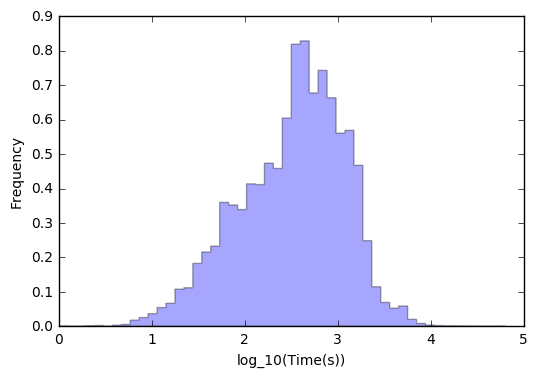

In [45]:
[F, x, p] = hist(np.log10(Tall), bins = 50, normed=True, histtype='stepfilled', alpha=0.35)
xlabel('log_10(Time(s))')
ylabel('Frequency')

可以看到现在的分布比较好看了，也具有更“好”的性质了（其实就是长的像正态，至于是不是正态应该qqplot一下）

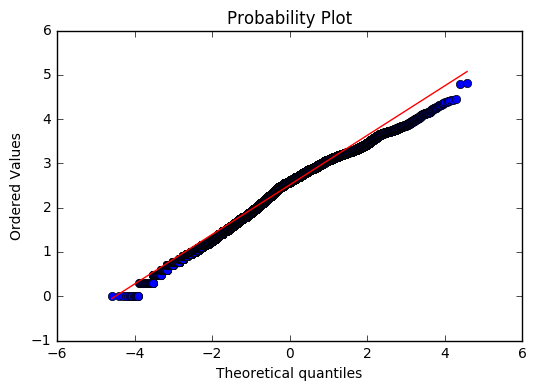

In [9]:
import pylab 
import scipy.stats as stats
# stats.probplot(np.log10(Tall).reshape((len(Tall),)), dist=stats.nct, sparams=(150, 0.2), plot=pylab)
stats.probplot(np.log10(Tall).reshape((len(Tall),)), dist="norm", plot=pylab)
pylab.show()

可以看到，还是基本符合正态分布的。

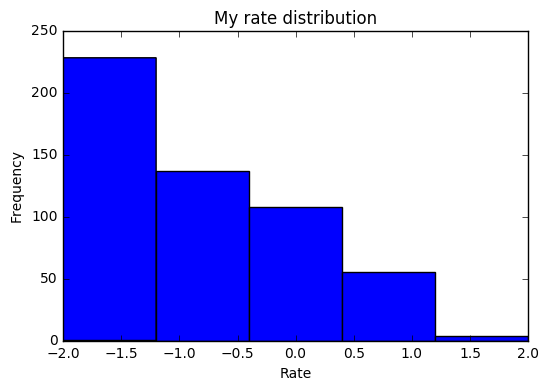

In [10]:
[F, x, p] = hist(y, bins = 5)
xlabel('Rate')
ylabel('Frequency')
title('My rate distribution')



## 性癖的机器学习
我为381部电影打了分，当然是根据个人的喜好，比如我对平刘海有着深刻的好感，没有平刘海简直就不是女生（逃

为了让机器知道我喜欢那些电影，以后自动帮我下载（误

我需要让机器学习一下我的癖好，就根据网站上的标签（我称之为Tag，其实是Categories）

In [46]:
considerTime = False
import random
if considerTime:
    Xt = np.concatenate((np.log10(T), X), axis=1)
else:
    Xt = X
index = [i for i in range(len(y))]
random.shuffle(index)
Xt = Xt[index,:]
y = y[index]
testRange = int(len(y)*0.15)
Xt_test = Xt[:testRange,:]
y_test = y[:testRange]
Xt_train = Xt[testRange:,:]
y_train = y[testRange:]
print "Test:%d, Train:%d" % (len(y_test), len(y_train))
print "Positive rate:%f%%" % (sum(y>-0.5)[0]*100.0/len(y))

Test:79, Train:453
Positive rate:31.390977%


### 使用Logistic模型对性癖进行学习
下面是用Logistic Regression对性癖进行学习，使用了sklearn中的LogisticRegressionCV（带交叉验证的Logistic回归）
我特地没有考虑时间，因为实际验证的时候，因为有些片子的时间有错误，有的长达十几个小时，导致推荐的都是这些乱七八糟的影片。
虽然使用时间能达到更高的精度，但是却和“学习性癖”这个主题背道而驰了。

In [51]:
import sklearn.linear_model
regr = sklearn.linear_model.LogisticRegressionCV(
    Cs=60, fit_intercept=True, cv=4, dual=False, 
    penalty='l2', scoring=None, solver='lbfgs', tol=0.0001, 
    max_iter=1000, class_weight=None, n_jobs=1, verbose=1)
regr.fit(Xt_train, y_train>-0.5)

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.1s finished


LogisticRegressionCV(Cs=60, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=1)

In [52]:
y_train_predict = regr.predict(Xt_train)
y_test_predict = regr.predict(Xt_test)
y_train_real = np.reshape(y_train>-0.5,y_train_predict.shape)
y_test_real = np.reshape(y_test>-0.5,y_test_predict.shape)

In [53]:
# 输出报告
from sklearn import metrics
print('------------ACCURACY-------------')
print "Train accuracy: %f%%" % (sum(y_train_predict==y_train_real)*100.0/len(y_train_real))
print "Test accuracy: %f%%" % (sum(y_test_predict==y_test_real)*100.0/len(y_test_real))

------------ACCURACY-------------
Train accuracy: 68.211921%
Test accuracy: 70.886076%


In [54]:
print('-------------REPORT-------------')
print('TRAIN RESULT')
print(metrics.classification_report(y_train_real, y_train_predict))
print('TRAIN CONFUSION MATRIX')
print(metrics.confusion_matrix(y_train_real, y_train_predict))

print('TEST RESULT')
print(metrics.classification_report(y_test_real, y_test_predict))
print('TEST CONFUSION MATRIX')
print(metrics.confusion_matrix(y_test_real, y_test_predict))

-------------REPORT-------------
TRAIN RESULT
             precision    recall  f1-score   support

      False       0.68      1.00      0.81       309
       True       0.00      0.00      0.00       144

avg / total       0.47      0.68      0.55       453

TRAIN CONFUSION MATRIX
[[309   0]
 [144   0]]
TEST RESULT
             precision    recall  f1-score   support

      False       0.71      1.00      0.83        56
       True       0.00      0.00      0.00        23

avg / total       0.50      0.71      0.59        79

TEST CONFUSION MATRIX
[[56  0]
 [23  0]]


/home/yuanyifan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
print "coefficients:",regr.coef_        #与X结合的值  
print "intercept:",regr.intercept_         #类似于截距  

coefficients: [[-0.03172487  0.16995903  0.09398287 ...,  0.          0.10091245
   0.03079246]]
intercept: [-1.31674931]


In [27]:
index = np.argsort(regr.coef_[0])
tag_sorted = []
for i in index:
    tag_sorted.append(tag_list[i])

# 显示对分类有正贡献的词汇和负贡献的词汇
N = 20
print "Positive top N words:",",".join(tag_sorted[-N:])
print "Negative top N words:",",".join(tag_sorted[:N])

Positive top N words: Fucking,Porno Vrai,Blowjobs,German,Shaved,French,Young Masturbating,Masturbating,Chubby,Sexy Latina,Fisting and Squirting,Teens,Gangbang,Pussy Fucking,Muscular Women,Double Penetration,Hardcore,Creampie,Japanese,Anal
Negative top N words: Amateur,Close-ups,Throat Fuck,Big Dick,Bisexuals,Sexy Horny,Flashing,Outdoor,Hidden Cams,Public Nudity,Redheads,Wife,Sofia Gucci,Anal Fuck,Granny,Cock Suckers,Student,Oral,Mexican,Private


### 使用线性回归对影片进行评分估测
下面尝试使用线性回归对我的打分进行分析，但是这种方法并不好，首先我打分并不一定符合实际的分布，要适应实际分布就要引入非线性算法，就要降低可解释性，或者陷入对打分使用一个单调增函数进行变换，然后无尽的调整这个函数的江局中去。

In [49]:
import sklearn.linear_model
lasso_ratemodel = sklearn.linear_model.LassoCV(
    eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, 
    normalize=False, precompute='auto', max_iter=1000, tol=0.0001, 
    copy_X=True, cv=None, verbose=True, n_jobs=1, positive=False, 
    random_state=None, selection='cyclic')

lasso_ratemodel.fit(Xt_train, y_train.reshape((len(y_train),)))

............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min finished


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=True)

Train error: 1.01993 Test error: 1.10948


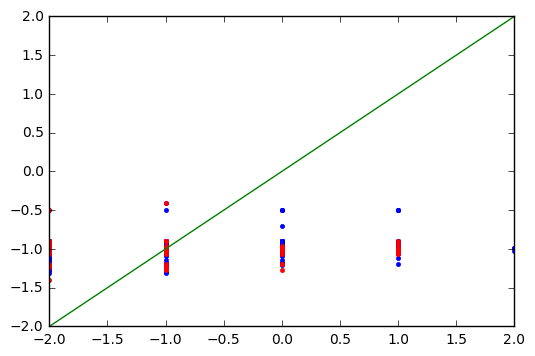

In [50]:
y_train_predict = lasso_ratemodel.predict(Xt_train)
y_test_predict = lasso_ratemodel.predict(Xt_test)
plot(y_train,y_train_predict,'b.',y_test,y_test_predict,'r.',[-2,2],[-2,2],'g-')
import sklearn.metrics as skm
r_train = np.sqrt(skm.mean_squared_error(y_train_predict,y_train))
r_test = np.sqrt(skm.mean_squared_error(y_test_predict,y_test))
print "Train error:", r_train, "Test error:", r_test

### Logistic模型实战用于影片推荐
所以我们最后还是选择了Logistic回归为我的影片进行打分。
下面是用训练好的Logistic模型为我爬虫爬到的所有电影打分，并且我使用了一个django网站来显示这些影片的预览，来看看和我的喜好是否相符合。

In [ ]:
from scipy import sparse
if considerTime:
    Xpred = np.zeros(
            (len(result_set_all), len(tag_index_dict)+ 1), 
            dtype="float32" )
    for i in range(len(result_set_all)):
        Xpred[i, 0] = np.log10(result_set_all[i][-1])
        for tag in result_set_all[i][3]:
            if tag_index_dict.has_key(tag):
                Xpred[i, tag_index_dict[tag] + 1] = 1
else:
    Xpred = np.zeros(
            (len(result_set_all), len(tag_index_dict)), 
            dtype="float32" )
    for i in range(len(result_set_all)):
        for tag in result_set_all[i][3]:
            if tag_index_dict.has_key(tag):
                Xpred[i, tag_index_dict[tag]] = 1
Xpred = sparse.coo_matrix(Xpred)

In [ ]:
yp = regr.predict(Xpred)
pr = regr.predict_proba(Xpred)

In [ ]:
prob_pos = pr[:,1]
prob_pos = np.sort(prob_pos)
plot(prob_pos[1:3000]) # 观察SORT后前3000部电影的Value

In [ ]:
Write2SQL=False
if Write2SQL:
    conn = genSQLConnection()
    cur = conn.cursor()
    for i in xrange(len(result_set_all)):
        sql_cmd = "UPDATE public.xhamster_spider SET recommand_info=%f WHERE id=%d;" % (pr[i,0], result_set_all[i][0])
        cur.execute(sql_cmd)
        conn.commit()
        if i % 10000 == 0:
            print "%d logs finished." % i
    cur.close()

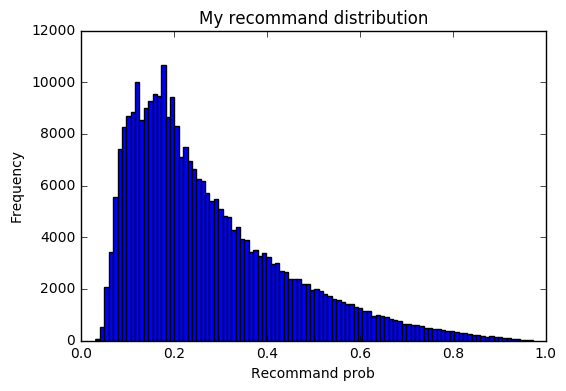

In [30]:
conn = genSQLConnection()
cur = conn.cursor()
sql_cmd = "select recommand_info from public.xhamster_spider"
cur.execute(sql_cmd)
res = cur.fetchall()
cur.close()
conn.close()
res = [x[0] for x in res]
[F, x, p] = hist(1-np.array(res), bins = 100)
xlabel('Recommand prob')
ylabel('Frequency')
title('My recommand distribution')

Test:79, Train:453
Positive rate:31.390977%
